# Importing All Libraries

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer

# Loading Dateset

In [32]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_sentiments.csv')
df = df.drop_duplicates()


In [33]:
df = df.drop('Unnamed: 0', axis=1)

In [36]:
positive_reivew = df[df['Score']=='positive'][:100]
negative_review = df[df['Score']=='negative'][:100]
neutral_review = df[df['Score']=='neutral'][:100]

In [38]:
positive_reivew.shape, negative_review.shape, neutral_review.shape

((100, 2), (100, 2), (100, 2))

In [ ]:
df.shape

(568454, 2)

In [ ]:
df.head(10)

,text,Score
0,This seems a little more wholesome than some o...,neutral
1,"The flavors are good. However, I do not see a...",neutral
2,This is the same stuff you can buy at the big ...,neutral
3,we're used to spicy foods down here in south t...,neutral
4,Watch your prices with this. While the assort...,neutral
5,"If you're impulsive like me, then $6 is ok. Do...",neutral
6,"The taste was great, but the berries had melte...",neutral
7,While my dogs like all of the flavors that we ...,neutral
8,"Awesome dog food. However, when given to my ""B...",neutral
9,not what I was expecting in terms of the compa...,neutral


In [ ]:
df.tail()

,text,Score
568449,Great for sesame chicken..this is a good if no...,positive
568450,I'm disappointed with the flavor. The chocolat...,negative
568451,"These stars are small, so you can give 10-15 o...",positive
568452,These are the BEST treats for training and rew...,positive
568453,"I am very satisfied ,product is as advertised,...",positive


In [ ]:
df['Score'].value_counts()

positive    443777
negative     82037
neutral      42640
Name: Score, dtype: int64

In [ ]:
df['Score'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

# **Positvie and Negative Review Separating**

In [ ]:
positive_re = df[df['Score']=='positive']['text']
negative_re = df[df['Score']=='negative']['text']

In [ ]:
positive_re.shape, negative_re.shape

((443777,), (82037,))

In [34]:
positive_reivew = df[df['Score']=='positive']
negative_review = df[df['Score']=='negative']

**Undersamplining the positive data into minority negative dataset**

In [ ]:
undersample_positive_reivew = positive_reivew[:82037]

In [ ]:
positive_reivew.shape

(443777, 2)

In [ ]:
negative_review.shape

(82037, 2)

In [ ]:
undersample_positive_reivew.shape

(82037, 2)

In [ ]:
df_upos_neg = pd.concat([undersample_positive_reivew , negative_review])

In [ ]:
df_upos_neg.head()

,text,Score
42640,I have bought several of the Vitality canned d...,positive
42642,This is a confection that has been around a fe...,positive
42644,Great taffy at a great price. There was a wid...,positive
42645,I got a wild hair for taffy and ordered this f...,positive
42646,This saltwater taffy had great flavors and was...,positive


In [ ]:
df_upos_neg['Score'].value_counts()

negative    82037
positive    82037
Name: Score, dtype: int64

In [ ]:
df_upos_neg.shape

(164074, 2)

In [ ]:
df_upos_neg.tail()

,text,Score
568433,I just bought this soup today at my local groc...,negative
568434,This soup is mostly broth. Although it has a k...,negative
568435,"It is mostly broth, with the advertised 3/4 cu...",negative
568446,I had ordered some of these a few months back ...,negative
568450,I'm disappointed with the flavor. The chocolat...,negative


# **EDA on Dataset**

In [ ]:
# Checking null Value on Datasets
df.isnull().sum()

text     0
Score    0
dtype: int64

### **SNS Plot of Dataset**

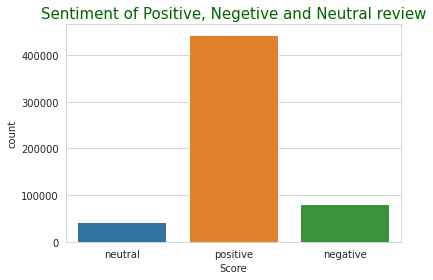

In [ ]:
sns.set_style('whitegrid')
plt.title('Sentiment of Positive, Negetive and Neutral review',fontsize=15, color='darkgreen')
sns.countplot(x='Score',data=df)

## **Word Cloud of dataset**

In [ ]:
def create_cloud(string, title=None):
    cloud = WordCloud(height=1080, 
                      width=1920, 
                      background_color='white', 
                      min_font_size=10, 
                      stopwords=STOPWORDS).generate(string)
    plt.figure(figsize=(10,20))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    if title:
        plt.title(title, fontdict={'fontsize':24},color='#FFA300')
    plt.show()

**Positive Review wordcloud**

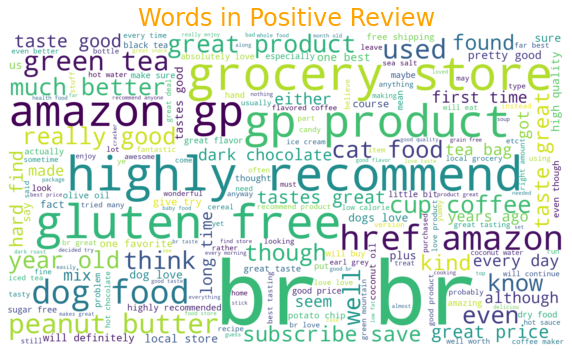

In [ ]:
create_cloud(" ".join(positive_re).lower(),'Words in Positive Review')


**Negative Review Wordcloud**

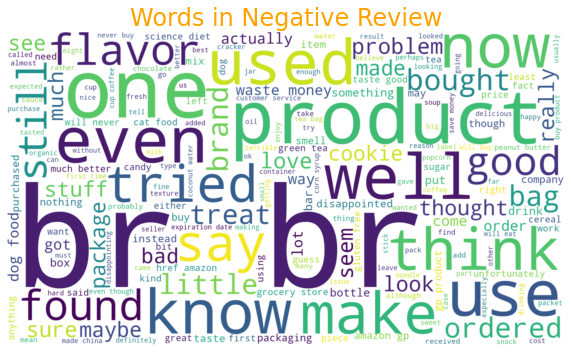

In [ ]:
create_cloud(" ".join(negative_re).lower(),'Words in Negative Review')


# **Text Cleaning, Lemataization, Stemming of the Dataset**

In [ ]:
def text_cleaning(data):
    from bs4 import BeautifulSoup
    import re
    def decontracted(phrase):
        # specific
        phrase= re.sub(r'<br /><br />',' ',phrase)
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r'"',' ',phrase)
        phrase = re.sub(r"_",' ',phrase)
        return phrase
    stopwords=set(STOPWORDS)

    # Combining all the above stundents 
    from tqdm import tqdm
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentance in tqdm(data['text'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e not in stopwords)
        preprocessed_reviews.append(sentance.strip())
    
    # PorterStemmer 
    from nltk.stem import PorterStemmer,LancasterStemmer
    poter  = PorterStemmer()
    lancaster = LancasterStemmer()
    lst_of_poter = []
    lst_of_lancaster = []
    for sentence in preprocessed_reviews:
      list_end = []
      for word in sentence.split():
        stem_word = poter.stem(word)
        list_end.append(stem_word)
      lst_of_poter.append(" ".join(list_end))
    # for loop of Lematization
    for sentence in lst_of_poter:
      list_end_2 = []
      for word in sentence.split():
        stem_word = lancaster.stem(word)
        list_end_2.append(stem_word)
      lst_of_lancaster.append(" ".join(list_end_2))



    return(lst_of_lancaster)

In [ ]:
x = text_cleaning(df_upos_neg)
df_upos_neg['cleaned_review']=x

100%|██████████| 164074/164074 [00:44<00:00, 3727.65it/s]


In [ ]:
df_upos_neg.head()

,text,Score,cleaned_review
42640,I have bought several of the Vitality canned d...,positive,i bought sev vit can dog food produc found goo...
42642,This is a confection that has been around a fe...,positive,"thi confect around centuries. it light, pillow..."
42644,Great taffy at a great price. There was a wid...,positive,gre taff gre price. ther wid assort yumm taffy...
42645,I got a wild hair for taffy and ordered this f...,positive,i got wild hair taff ord fiv pound bag. the ta...
42646,This saltwater taffy had great flavors and was...,positive,thi saltw taff gre flav soft chewy. each cand ...


In [ ]:
df_upos_neg.shape

(164074, 3)

In [ ]:
df_x = df_upos_neg['cleaned_review']
df_y = df_upos_neg['text']

In [ ]:
df_x.shape, df_y.shape


((164074,), (164074,))

## **Spliting Dataset**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_x,df_y, test_size=0.20 , random_state=42)


In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((131259,), (32815,), (131259,), (32815,))

In [ ]:
x_train, x_cv, y_train, y_cv = train_test_split(x_train,y_train, test_size=0.25 , random_state=42)

In [ ]:
x_train.shape, x_cv.shape, y_train.shape, y_cv.shape


((98444,), (32815,), (98444,), (32815,))

In [ ]:
x_test.shape


(32815,)

# **BOW of dataset**

In [ ]:
vectorizer = CountVectorizer()
x_train_bow = vectorizer.fit_transform(x_train)
x_cv_bow = vectorizer.transform(x_cv)
x_test_bow = vectorizer.transform(x_test)
# print(vectorizer.get_feature_names())
print(x_train_bow.shape)
print(x_cv_bow.shape)
print(x_test_bow.shape)

(98444, 49436)
(32815, 49436)
(32815, 49436)


# **TFIDF of dataset**

In [ ]:
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(x_train)
x_cv_tfidf = vectorizer.transform(x_cv)
x_test_tfidf = vectorizer.transform(x_test)
# print(vectorizer.get_feature_names())
print(x_train_tfidf.shape)
print(x_cv_tfidf.shape)
print(x_test_tfidf.shape)

(98444, 49436)
(32815, 49436)
(32815, 49436)


# **KNN using BOW of Dataset**

In [ ]:
for i in range(40,51,2):
  print("k=",i)
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(x_train_bow, y_train)
  pred_train_bow=list(neigh.predict(x_train_bow))
  pred_cv_bow = list(neigh.predict(x_cv_bow))
  pred_test_bow =list(neigh.predict(x_test_bow))

  # Accuracy for Train
  accuracy_train = accuracy_score(y_train, pred_train_bow)
  print('Accuracy of train data:',accuracy_train)

  # Accuracy for CV
  accuracy_cv = accuracy_score(y_cv , pred_cv_bow)
  print('Accuracy of CV data:',accuracy_cv)

  # Accuracy for Test
  accuracy_test = accuracy_score(y_test, pred_test_bow)
  print('Accuracy of test data: ',accuracy_test)
  

k= 40
Accuracy of train data: 0.12735159075210273
Accuracy of CV data: 0.07819594697546854
Accuracy of test data:  0.07856163339936005
k= 42
Accuracy of train data: 0.12388769249522572
Accuracy of CV data: 0.0763979887246686
Accuracy of test data:  0.07658083193661436
k= 44
Accuracy of train data: 0.12068790378286132
Accuracy of CV data: 0.07450860886789577
Accuracy of test data:  0.07502666463507543
k= 46
Accuracy of train data: 0.11777254073381821
Accuracy of CV data: 0.07316775864696023
Accuracy of test data:  0.07389913149474325
k= 48
Accuracy of train data: 0.11470480679371013
Accuracy of CV data: 0.07130885265884504
Accuracy of test data:  0.07216212098125857
k= 50
Accuracy of train data: 0.11192149851692333
Accuracy of CV data: 0.06990705470059425
Accuracy of test data:  0.07048605820508913


# **KNN using TFIDF of Dataset**

In [ ]:
for i in range(100,111,2):
  print("k=",i)
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(x_train_tfidf, y_train)
  pred_train_tfidf=list(neigh.predict(x_train_tfidf))
  pred_cv_tfidf = list(neigh.predict(x_cv_tfidf))
  pred_test_tfidf=list(neigh.predict(x_test_tfidf))

  # Accuracy for Train
  accuracy_train = accuracy_score(y_train, pred_train_tfidf)
  print('Accuracy of train data:',accuracy_train)

  # Accuracy for CV
  accuracy_cv = accuracy_score(y_cv , pred_cv_tfidf)
  print('Accuracy of CV data:',accuracy_cv)

  # Accuracy for Test
  accuracy_test = accuracy_score(y_test, pred_test_tfidf)
  print('Accuracy of test data: ',accuracy_test)
  

k= 100


NameError: ignored

# **AUC-ROC Score of BOW Dataset**

In [ ]:
print('ROC-Score USing BOW Dataset:--->>')
print(" ")

roc_score_train_bow = roc_auc_score(y_train, neigh.predict_proba(x_train_bow)[:, 1])
roc_score_cv_bow = roc_auc_score(y_cv, neigh.predict_proba(x_cv_bow)[:, 1])
roc_score_test_bow = roc_auc_score(y_test, neigh.predict_proba(x_test_bow)[:, 1])
print('ROC SCORE of train data:',roc_score_train_bow)
print('ROC SCORE of CV Data:', roc_score_cv_bow)
print('ROC SCORE of test data: ',roc_score_test_bow)

ROC-Score USing BOW Dataset:--->>
 


ValueError: ignored

# **AUC-ROC Score of TFIDF Dataset**

In [ ]:
print('ROC-Score USing TFIDF Dataset:--->>')
print(" ")

roc_score_train_tfidf = roc_auc_score(y_train, neigh.predict_proba(x_train_tfidf)[:, 1])
roc_score_cv_tfidf = roc_auc_score(y_cv, neigh.predict_proba(x_cv_tfidf)[:, 1])
roc_score_test_tfidf = roc_auc_score(y_test, neigh.predict_proba(x_test_tfidf)[:, 1])
print('ROC SCORE of train data:',roc_score_train_tfidf)
print('ROC SCORE of CV Data:', roc_score_cv_tfidf)
print('ROC SCORE of test data: ',roc_score_test_tfidf)

ROC-Score USing TFIDF Dataset:--->>
 


ValueError: ignored

# **F1-Score of BOW Dataset**

In [ ]:
print('F1-Score USing BOW Dataset:--->>')
print(" ", end='\n')
f1_score_train_bow = f1_score(y_train, pred_train_bow, average='macro')
f1_score_cv_bow = f1_score(y_cv, pred_cv_bow, average='macro')
f1_score_test_bow = f1_score(y_test, pred_test_bow, average='macro')
print('for macro')
print('F1_Score of train data:',f1_score_train_bow)
print('F1_Score of CV data:',f1_score_cv_bow)
print('F1_Score of test data: ',f1_score_test_bow)
print()


f1_score_train_bow = f1_score(y_train, pred_train_bow, average='micro')
f1_score_cv_bow = f1_score(y_cv, pred_cv_bow, average='micro')
f1_score_test_bow = f1_score(y_test, pred_test_bow, average='micro')
print('for micro')
print('F1_Score of train data:',f1_score_train_bow)
print('F1_Score of CV data:',f1_score_cv_bow)
print('F1_Score of test data: ',f1_score_test_bow)
print()

f1_score_train_bow = f1_score(y_train, pred_train_bow, average='weighted')
f1_score_cv_bow = f1_score(y_cv, pred_cv_bow, average='weighted')
f1_score_test_bow = f1_score(y_test, pred_test_bow, average='weighted')
print('for weighted')
print('F1_Score of train data:',f1_score_train_bow)
print('F1_Score of CV data:',f1_score_cv_bow)
print('F1_Score of test data: ',f1_score_test_bow)
print()

# **F1-Socre of TFIDF Dataset**

In [ ]:
print('F1-Score USing TFIDF Dataset:--->>')
print(" ",end='\n')

f1_score_train_tfidf = f1_score(y_train, pred_train_tfidf, average='macro')
f1_score_cv_tfidf = f1_score(y_cv, pred_cv_tfidf, average='macro')
f1_score_test_tfidf = f1_score(y_test, pred_test_tfidf, average='macro')
print('for macro')
print('F1_Score of train data:',f1_score_train_tfidf)
print('F1_Score of CV data:',f1_score_cv_tfidf)
print('F1_Score of test data: ',f1_score_test_tfidf)
print()


f1_score_train_tfidf = f1_score(y_train, pred_train_tfidf, average='micro')
f1_score_cv_tfidf = f1_score(y_cv, pred_cv_tfidf, average='micro')
f1_score_test_tfidf = f1_score(y_test, pred_test_tfidf, average='micro')
print('for micro')
print('F1_Score of train data:',f1_score_train_tfidf)
print('F1_Score of CV data:',f1_score_cv_tfidf)
print('F1_Score of test data: ',f1_score_test_tfidf)
print()

f1_score_train_tfidf = f1_score(y_train, pred_train_tfidf, average='weighted')
f1_score_cv_tfidf = f1_score(y_cv, pred_cv_tfidf, average='weighted')
f1_score_test_tfidf = f1_score(y_test, pred_test_tfidf, average='weighted')
print('for weighted')
print('F1_Score of train data:',f1_score_train_tfidf)
print('F1_Score of CV data:',f1_score_cv_tfidf)
print('F1_Score of test data: ',f1_score_test_tfidf)
print()

# **Confusion Matrix of BOW Dataset**

In [ ]:
print('Confusion Matrix USing BOW Dataset:--->>')
print(" ",end='\n')

confusion_matrix_train_bow = confusion_matrix(y_train, pred_train_bow)
confusion_matrix_cv_bow = confusion_matrix(y_cv, pred_cv_bow)
confusion_matrix_test_bow = confusion_matrix(y_test, pred_test_bow)

print('confusion_matrix of train data:',confusion_matrix_train_bow)
print("")
print('confusion_matrix of CV data:',confusion_matrix_cv_bow)
print("")
print('confusion_matrix of test data: ',confusion_matrix_test_bow)

In [ ]:
plot_confusion_matrix(neigh,x_train_bow,y_train)

In [ ]:
plot_confusion_matrix(neigh,x_cv_bow,y_cv)

In [ ]:
plot_confusion_matrix(neigh,x_test_bow,y_cv)

# **Confusion Matrix of TFIDF Dataset**

In [ ]:
print('Confusion Matrix USing TFIDF Dataset:--->>')
print(" ", end='\n')
confusion_matrix_train_tfidf = confusion_matrix(y_train, pred_train_tfidf)
confusion_matrix_cv_tfidf = confusion_matrix(y_cv, pred_cv_tfidf)
confusion_matrix_test_tfidf = confusion_matrix(y_test, pred_test_tfidf)

print('confusion_matrix of train data:',confusion_matrix_train_tfidf)
print("")
print('confusion_matrix of CV data:',confusion_matrix_cv_tfidf)
print("")
print('confusion_matrix of test data: ',confusion_matrix_test_tfidf)

In [ ]:
plot_confusion_matrix(neigh,x_train_tfidf,y_train)

In [ ]:
plot_confusion_matrix(neigh,x_cv_tfidf,y_cv)

In [ ]:
plot_confusion_matrix(neigh,x_test_tfidf,y_test)

# **Classification Report of BOW Dataset**

In [ ]:
print('for train data set--->',end="\n")
print(classification_report(y_train, pred_train_bow))
print("")

print('for CV data set--->',end="\n")
print(classification_report(y_cv, pred_cv_bow))
print("")

print('for test data set--->',end="\n")
print(classification_report(y_test, pred_test_bow))

# **Classification Report of TFIDF Dataset**

In [ ]:
print('for train data set--->',end="\n")
print(classification_report(y_train, pred_train_tfidf))
print("")

print('for CV data set--->',end="\n")
print(classification_report(y_cv, pred_cv_tfidf))
print("")

print('for test data set--->',end="\n")
print(classification_report(y_test, pred_test_tfidf))